## Rigid body 6 DOF
Devlop a system for a rigid bofy in 6 DOF and do a simualtion

In [1]:
import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import sympy.physics.mechanics as me
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from substitute_dynamic_symbols import substitute_dynamic_symbols, find_name, find_derivative_name, lambdify, find_derivatives

from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint



In [3]:
x0,y0,z0 = me.dynamicsymbols('x0 y0 z0')
u,v,w = me.dynamicsymbols('u v w')

phi,theta,psi = me.dynamicsymbols('phi theta psi')
p,q,r = me.dynamicsymbols('p q r')

x01d,y01d,z01d = me.dynamicsymbols('x0 y0 z0',1)
x02d,y02d,z02d = me.dynamicsymbols('x0 y0 z0',2)

phi1d,theta1d,psi1d = me.dynamicsymbols('phi theta psi',1)
phi2d,theta2d,psi2d = me.dynamicsymbols('phi theta psi',2)


p_x = sp.Symbol('p_x')
p_y = sp.Symbol('p_y')
p_z = sp.Symbol('p_z')



In [4]:
x02d

Derivative(x0(t), (t, 2))

In [5]:
N = me.ReferenceFrame('N')

In [6]:
S = N.orientnew('S', 'Body', [psi,theta,phi],'ZYX')

In [7]:
S.ang_vel_in(N)

(-sin(theta)*psi' + phi')*S.x + (sin(phi)*cos(theta)*psi' + cos(phi)*theta')*S.y + (-sin(phi)*theta' + cos(phi)*cos(theta)*psi')*S.z

In [8]:
S.ang_acc_in(N)

(-sin(theta)*psi'' - cos(theta)*psi'*theta' + phi'')*S.x + (-sin(phi)*sin(theta)*psi'*theta' + sin(phi)*cos(theta)*psi'' - sin(phi)*phi'*theta' + cos(phi)*cos(theta)*phi'*psi' + cos(phi)*theta'')*S.y + (-sin(phi)*cos(theta)*phi'*psi' - sin(phi)*theta'' - sin(theta)*cos(phi)*psi'*theta' + cos(phi)*cos(theta)*psi'' - cos(phi)*phi'*theta')*S.z

In [15]:
M = me.Point('M')  # Origo of measurement system
M.set_vel(N, 0)

O = me.Point('O') # Origo of ship
O.set_pos(M,x0*N.x + y0*N.y + z0*N.z)
O.set_vel(N,u*N.x + v*N.y + w*N.z)

In [19]:
O.vel(N)

u*N.x + v*N.y + w*N.z

## Mass

In [20]:
mass = sp.symbols('m')
#x_g, y_g, z_g = sp.symbols('x_g y_g z_g')

In [21]:
#c_og = me.Point('c_og')
#c_og.set_pos(O,x_g*S.x + y_g*S.y + z_g*S.z)
#c_og.set_vel(S,0)

In [22]:
#c_og.v2pt_theory(O,N,S)

## Inertia

In [23]:
I_xx, I_yy, I_zz = sp.symbols('I_xx, I_yy, I_zz')
body_inertia_dyadic = me.inertia(S, ixx=I_xx, iyy=I_yy, izz=I_zz)
body_inertia_dyadic

I_xx*(S.x|S.x) + I_yy*(S.y|S.y) + I_zz*(S.z|S.z)

In [24]:
body_inertia_dyadic.to_matrix(S)

Matrix([
[I_xx,    0,    0],
[   0, I_yy,    0],
[   0,    0, I_zz]])

In [25]:
body_central_inertia = (body_inertia_dyadic, O)

In [26]:
body = me.RigidBody('Rigid body', masscenter=O, frame = S,
                      mass=mass, inertia=body_central_inertia)

## Forces

In [27]:
fx, fy, fz, mx, my, mz = sp.symbols('f_x f_y f_z m_x m_y m_z')

In [28]:
force_vector = fx*N.x + fy*N.y + fz*N.z
torque_vector = mx*N.x + my*N.y + mz*N.z

In [49]:
force = (O, force_vector)
torque = (S, torque_vector)

## Equations of Motion

In [50]:
coordinates = [x0, y0, z0, phi, theta, psi]
speeds = [u, v, w, p, q, r]

In [51]:
kinematical_differential_equations = [x0.diff() - u,                                      
                                      y0.diff() - v,
                                      z0.diff() - w,
                                      phi.diff() - p,
                                      theta.diff() - q,
                                      psi.diff() - r,
                                     ]

In [52]:
#?me.KanesMethod

In [53]:
kane = me.KanesMethod(N, coordinates, speeds, kinematical_differential_equations)

In [54]:
loads = [force,
         torque]

In [55]:
bodies = [body]
fr, frstar = kane.kanes_equations(bodies, loads)

In [56]:
constants = [I_xx, I_yy, I_zz,mass]

specified = [fx, fy, fz, mx, my, mz]  # External force/torque

right_hand_side = generate_ode_function(kane.forcing_full, coordinates,
                                        speeds, constants,
                                        mass_matrix=kane.mass_matrix_full,specifieds=specified)

In [57]:
coordinates_ = [0, 0, 0, 0, 0, 0]
speeds_ = [0, 0, 0, 0, 0, 0]

start = np.array(coordinates_+speeds_)

t = 0.
force_torque = [1,0,0,0,0,0]
numerical_specified = np.array(force_torque)

I_xx_ = 1
I_yy_ = 1
I_zz_ = 1
mass_ = 1

numerical_constants = np.array([I_xx_, I_yy_, I_zz_,mass_])

right_hand_side(start,t,numerical_specified, numerical_constants)

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [64]:
def simulate(t,force_torque, I_xx,I_yy,I_zz,mass, initial_coordinates = [0, 0, 0, 0, 0, 0], 
             initial_speeds = [0, 0, 0, 0, 0, 0]):
    
    start = np.array(initial_coordinates+initial_speeds)
    
    numerical_specified = force_torque
        
    numerical_constants = np.array([I_xx, I_yy, I_zz, mass])
    
    df = pd.DataFrame(index=t)
    y = odeint(right_hand_side, start, t, args=(numerical_specified, numerical_constants))
    
    for i,symbol in enumerate(coordinates+speeds):
        name = symbol.name
        df[name] = y[:,i]
        
    return df

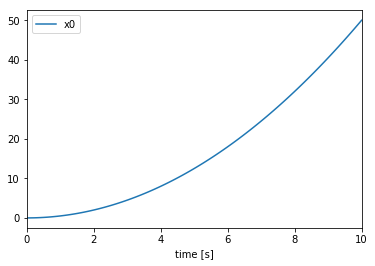

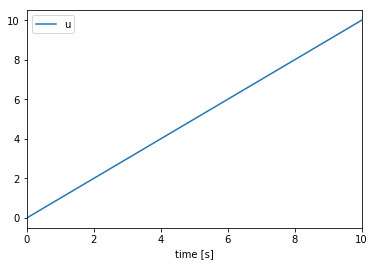

In [66]:
t = np.linspace(0,10,100)

coordinates_ = [0, 0, 0, 0, 0, 0]
speeds_ = [0, 0, 0, 0, 0, 0]

start = np.array(coordinates_+speeds_)

df = simulate(t=t, force_torque=[1,0,0,0,0,0],I_xx=1, I_yy=1, I_zz=1, mass=1)


fig,ax = plt.subplots()
df.plot(y='x0', ax=ax);
ax.set_xlabel('time [s]')

fig,ax = plt.subplots()
df.plot(y='u', ax=ax);
ax.set_xlabel('time [s]');

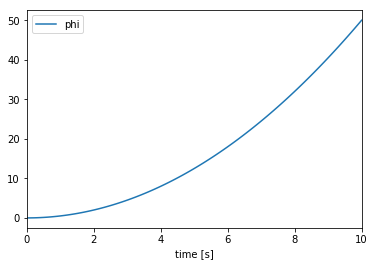

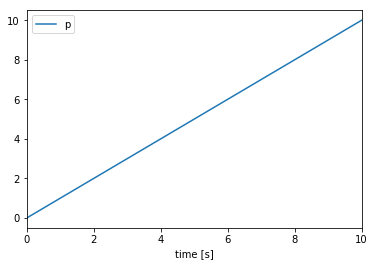

In [67]:
t = np.linspace(0,10,100)

coordinates_ = [0, 0, 0, 0, 0, 0]
speeds_ = [0, 0, 0, 0, 0, 0]

start = np.array(coordinates_+speeds_)

df = simulate(t=t, force_torque=[0,0,0,1,0,0],I_xx=1, I_yy=1, I_zz=1, mass=1)


fig,ax = plt.subplots()
df.plot(y='phi', ax=ax);
ax.set_xlabel('time [s]')

fig,ax = plt.subplots()
df.plot(y='p', ax=ax);
ax.set_xlabel('time [s]');

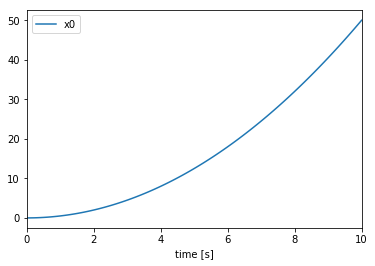

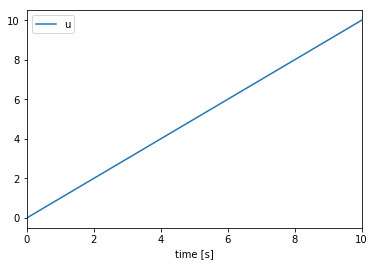

In [70]:
t = np.linspace(0,10,100)

coordinates_ = [0, 0, 0, 0, 0, 0]
speeds_ = [0, 0, 0, 0, 0, 0]

start = np.array(coordinates_+speeds_)

df = simulate(t=t, force_torque=[1,1,1,0,0,0],I_xx=1, I_yy=1, I_zz=1, mass=1)


fig,ax = plt.subplots()
df.plot(y='x0', ax=ax);
ax.set_xlabel('time [s]')

fig,ax = plt.subplots()
df.plot(y='u', ax=ax);
ax.set_xlabel('time [s]');